#  Forest Cover Type Prediction

---
![](https://images.unsplash.com/photo-1440342359743-84fcb8c21f21?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1350&q=80)
Picture by [kazuend](https://unsplash.com/photos/19SC2oaVZW0)

**Q1 - Load the data**

Follow this link to download the data: https://drive.google.com/open?id=1ybK_g8jFfxDcWwjei9OADuTydnMz9124

In [3]:
# TODO
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local[*]').appName('ForestCover').getOrCreate()

In [7]:
print(spark.sparkContext.uiWebUrl)

http://192.168.0.19:4041


In [42]:
df = spark.read.csv('/home/guillaume/code/GGIML/vivadata-student/data/forest_cover/train-set.csv',
                     header=True, inferSchema=True)

## 1. Logistic Regression : 

The goal here is to understand how to run a Linear Regression Algorithms on the Data.

In [43]:
# TODO : print your dataset size
print((df.count(), len(df.columns)))

(528720, 56)


**Q2 - Use `VectorAssembler()` to merge our feature columns into a single vector column as requiered by Spark methods.***

In [44]:
inputcol = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways", "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm", "Horizontal_Distance_To_Fire_Points", "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3", "Wilderness_Area4", "Soil_Type1", "Soil_Type2", "Soil_Type3", "Soil_Type4", "Soil_Type5", "Soil_Type6", "Soil_Type7", "Soil_Type8", "Soil_Type9", "Soil_Type10", "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14", "Soil_Type15", "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19", "Soil_Type20", "Soil_Type21", "Soil_Type22", "Soil_Type23", "Soil_Type24", "Soil_Type25", "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29", "Soil_Type30", "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34", "Soil_Type35", "Soil_Type36", "Soil_Type37", "Soil_Type38", "Soil_Type39", "Soil_Type40"]

# TODO
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=inputcol, outputCol='features')

In [45]:
total_count = df.count()
count_df = df.groupBy('Cover_Type').count()
count_df = count_df.withColumn('percentage', count_df['count']/total_count).show()

+----------+------+--------------------+
|Cover_Type| count|          percentage|
+----------+------+--------------------+
|         1|192511|   0.364107656226358|
|         6| 15687|0.029669768497503406|
|         3| 32598| 0.06165456196096233|
|         5|  8676|0.016409441670449387|
|         4|  2503|0.004734074746557724|
|         7| 18756|0.035474353154788925|
|         2|257989| 0.48795014374338025|
+----------+------+--------------------+



In [46]:
train_df = df.sampleBy("Cover_Type", fractions={1: 0.8, 2: 0.8, 3: 0.8, 4: 0.8, 5: 0.8, 6: 0.8, 7: 0.8}, seed=42)

In [47]:
test_df = df.subtract(train_df)

In [48]:
print((train_df.count(), len(train_df.columns)))
print((test_df.count(), len(test_df.columns)))

(422908, 56)
(105812, 56)


**Q3 - Use `Logistic Regression` to define the classifier.**

In [49]:
# TODO
from pyspark.mllib.classification import LogisticRegression

logr = LogisticRegression(featuresCol = 'features', labelCol='Cover_Type')

**Q4 - Create a pipeline that will chain the vector assambler and the classifier stages.**

In [50]:
# Chain vecAssembler and classification model 
from pyspark.ml.pipeline import Pipeline

pipe = Pipeline(stages=[assembler, logr])

# Run stages in pipeline with the train data
model = pipe.fit(train_df)

**Q5 - Once we have trained the classifier, we can use it to make predictions on the test data.**

In [53]:
# Make predictions on testData
predictions = model.transform(test_df)

In [54]:
# Show the content of 'predictions'
predictions.select('raWPrediction','probability', 'prediction').show()

+--------------------+--------------------+----------+
|       raWPrediction|         probability|prediction|
+--------------------+--------------------+----------+
|[-8.7762130191404...|[5.35345858389372...|       2.0|
|[-8.7794931183245...|[9.28441879726121...|       1.0|
|[-8.7840213345068...|[1.86008743385490...|       2.0|
|[-8.7799272125552...|[2.41930694330718...|       2.0|
|[-8.7808004871736...|[4.95429563234496...|       2.0|
|[-8.7764739369276...|[1.55375319935563...|       2.0|
|[-8.7812991876534...|[1.84650877418513...|       1.0|
|[-8.7861425171993...|[4.71813442840067...|       1.0|
|[-8.7831006655145...|[1.80426281601324...|       2.0|
|[-8.7821232773328...|[5.91833657554378...|       1.0|
|[-8.7784144399904...|[1.22007926855750...|       2.0|
|[-8.7772227435178...|[2.66331736685972...|       3.0|
|[-8.7789571496242...|[1.84967462137713...|       2.0|
|[-8.7803780407016...|[3.66504426931112...|       1.0|
|[-8.7817906049125...|[1.99071194957161...|       2.0|
|[-8.77991

**Q6 - Compute the accuracy score.**

In [65]:
# Accuracy
trainingSummary = model.stages[1].summary

In [68]:
print("Accuracy: %f" % trainingSummary.accuracy)

Accuracy: 0.709937


In [69]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [70]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='Cover_Type', metricName='accuracy')

In [71]:
evaluator.evaluate(predictions)

0.7137281215741126

## 2. DecisionTreeClassifier : 

**Q7 - Execute the same step as before and adapt your code to the Decision Tree algorithm.**

In [72]:
# Chain vecAssembler and classification model
from pyspark.ml.classification import DecisionTreeClassifier

tree = DecisionTreeClassifier(featuresCol = 'features', labelCol='Cover_Type')

pipe_tree = Pipeline(stages=[assembler, tree])

# Train model.
model_tree = pipe_tree.fit(train_df)

# Make predictions.
pred_tree = model_tree.transform(test_df)

# Select example rows to display.
pred_tree.select('Cover_Type', 'prediction').head(5)

# Select (prediction, true label) and compute test error
evaluator.evaluate(pred_tree)

0.7006010660416588

In [81]:
# Same with Scikit-learn's accuracy score
from sklearn.metrics import accuracy_score

accuracy_score(test_df.select('Cover_Type').toPandas(), pred_tree.select('prediction').toPandas())

/home/guillaume/.pyenv/versions/3.7.6/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


0.7006010660416588

## 3. Random Forest Classifier :

**Q8 - Execute the same step as before and adapt your code to the Random Forest algorithm.**

In [83]:
# Chain indexers and forest in a Pipeline
from pyspark.ml.classification import RandomForestClassifier

rfc = RandomForestClassifier(featuresCol = 'features', labelCol='Cover_Type', maxDepth=10)

pipe_forest = Pipeline(stages=[assembler, rfc])

# Train model.
model_forest = pipe_forest.fit(train_df)

# Make predictions.
pred_forest = model_forest.transform(test_df)

# Select example rows to display.

# Select (prediction, true label) and compute test error
evaluator.evaluate(pred_forest)

0.7337636562960723

In [ ]:
# Same with Scikit-learn's accuracy score

## 4. Correlation and preparation Data processing

It is also possible to realise Correlation Matric to see which are the important features.

**Q9 - Display the statistic values of the Correlation Matrix.**

In [90]:
df = assembler.transform(df)

In [108]:
# TODO
from pyspark.ml.stat import Correlation

corr = Correlation.corr(df, 'features').collect()[0][0]
print("Pearson correlation matrix:\n" + str(corr))

Pearson correlation matrix:
DenseMatrix([[ 1.        ,  0.01652763, -0.24059199, ...,  0.21720573,
               0.19306771,  0.21238823],
             [ 0.01652763,  1.        ,  0.07790496, ...,  0.01849119,
               0.0087294 , -0.00473708],
             [-0.24059199,  0.07790496,  1.        , ..., -0.07181315,
               0.09371868,  0.02573516],
             ...,
             [ 0.21720573,  0.01849119, -0.07181315, ...,  1.        ,
              -0.0258823 , -0.02060533],
             [ 0.19306771,  0.0087294 ,  0.09371868, ..., -0.0258823 ,
               1.        , -0.01928071],
             [ 0.21238823, -0.00473708,  0.02573516, ..., -0.02060533,
              -0.01928071,  1.        ]])


Obviously, you can't say anything with those values.

**Q10 - Plot the Correlation Matrix using `seaborn.heatmap`**

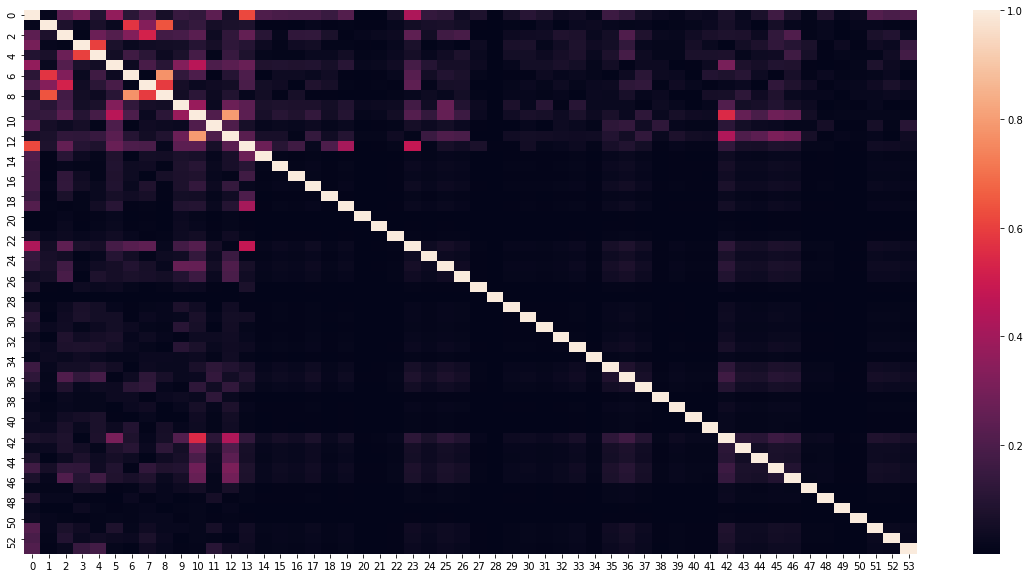

In [118]:
# TODO
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,10))
sns.heatmap(abs(corr.toArray()))
plt.show()

**Q11 - Going further [optionnal] :** 
* Try to avoid overfitting  
* Realise some cross validation to improve the score.